In [81]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['figure.figsize'] = 12, 6
import jupytertools

In [82]:
def eulerCromer(x_i,y_i,
                vx_i,vy_i,
                g,b_over_m,
                delta_t):
    '''
    Calculate the new values for v_x, v_y, x, and y using the Euler-Cromer method
    '''
    # calculate the current magnitude of the velocity vector
    v_i = np.sqrt(vx_i**2 + vy_i**2)

    # calculate the new x- and y-components of the velocity
    vx_new = vx_i - b_over_m*vx_i*v_i*delta_t
    vy_new = vy_i - (b_over_m*vy_i*v_i + g)*delta_t
    
    x_new = x_i + vx_new*delta_t
    y_new = y_i + vy_new*delta_t
    
    return vx_new,vy_new,x_new,y_new

In [83]:
def generateTrajectory(theta, v_0, g, R, delta_t, rho_o, rho_s=1):
    '''
    Generate the trajectory of our projectile with the Euler-Cromer method
    '''
    theta = np.radians(theta)
    b_over_m = 3*rho_s/(16*rho_o*R)
    
    x_vals = [0.0]
    y_vals = [0.0]
    vx_vals = [v_0*np.cos(theta)]
    vy_vals = [v_0*np.sin(theta)]

    while y_vals[-1] >= 0:
        vx_new, vy_new, x_new, y_new = eulerCromer(x_vals[-1],y_vals[-1],
                                                   vx_vals[-1],vy_vals[-1],
                                                   g,b_over_m,delta_t)
        x_vals.append(x_new)
        y_vals.append(y_new)
        vx_vals.append(vx_new)
        vy_vals.append(vy_new)
        
    return x_vals,y_vals

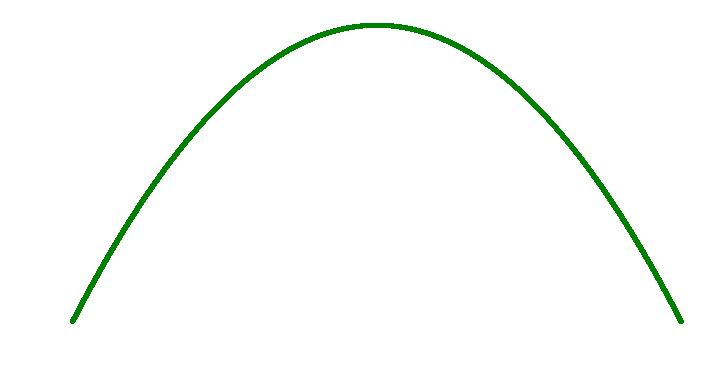

883.699250218 -0.000418371463552


In [84]:
x,y = generateTrajectory(30,100,9.80,0.01,0.00001,8000,0)

jupytertools.plotting.darkPlot(x,y,'g.')
print(x[-1],y[-1])

In [85]:
def dist(theta, v0, g, R, delta_t,rho_o, rho_s=1):
    '''
    Calculate the distance traveled by some spherical projectile with some density rho_o through
    some arbitrary medium with density rho_s which has gravity g where the projectile is 
    launched with some initial angle theta. 
    '''    
    x,y = generateTrajectory(theta, v0, g, R, delta_t, rho_o, rho_s)
    
    # do the linear interpolation of the trajectory
    end_x = x[-2:]
    end_y = y[-2:]
    
    slope = (end_y[0] - end_y[1])/(end_x[1] - end_x[0])
    
    x_adj = end_y[1]/slope
    
    return x[-1] + x_adj

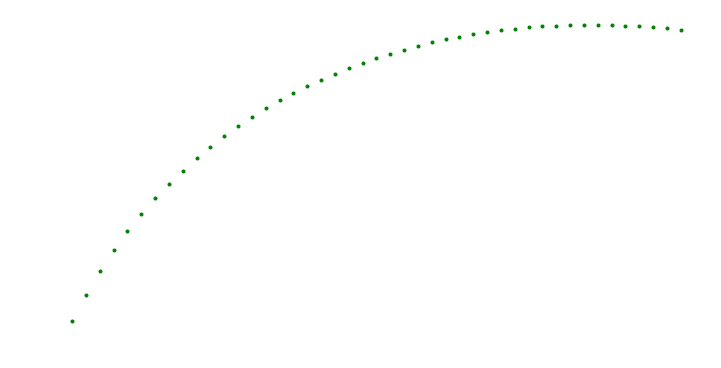

In [86]:
dist(30,100,9.80,0.01,1e-5,8000,0)

dists = []

for i in range(45):
    dists.append(dist(i,100,9.80,0.01,0.001,8000,1.2))
    
jupytertools.plotting.darkPlot(np.arange(0,45),dists,"g.")

In [87]:
def findMaxDist(v0,g,R,rho_o,rho_s):
    '''
    Use the principles of binary search to find the angle which produces the maximum distance 
    which the projectile can travel with the given initial conditions. 
    
    The algorithm we will use will work as follows.
    
    First, calculate the distance travelled with an initial angle of 0 degrees, 22.5 degrees,
    and an angle of 45 degrees. Then if the distance traveled by 22.5 degrees is greater than 
    the distance travelled with 45 degrees we will make 11.125 the new base and 22.5 + 11.125
    the new max and then repeat.
    '''
    
    min_angle = 0
    max_angle = 45
    mid_angle = (min_angle + max_angle)/2
    angle_step = mid_angle/4
    delta_t = 0.001
    
    
    min_angle_dist = dist(min_angle, v0, g, R, delta_t,rho_o, rho_s)
    max_angle_dist = dist(max_angle, v0, g, R, delta_t,rho_o, rho_s)
    mid_angle_dist = dist(mid_angle, v0, g, R, delta_t,rho_o, rho_s)
    
    while (max_angle - mid_angle > 0.0001):
        if (max_angle - min_angle < 1):
            delta_t = 0.0001
        elif (max_angle - min_angle < 0.1):
            delta_t = 0.00001
        elif (max_angle - min_angle < 0.01):
            delta_t = 0.0000001
        elif (max_angle - min_angle < 0.001):
            delta_t = 0.00000001
        min_angle_dist = dist(min_angle, v0, g, R, delta_t,rho_o, rho_s)
        max_angle_dist = dist(max_angle, v0, g, R, delta_t,rho_o, rho_s)
        mid_angle_dist = dist(mid_angle, v0, g, R, delta_t,rho_o, rho_s)
    
        #print("current ",max_angle,min_angle,max_angle_dist,mid_angle_dist,min_angle_dist)
    
        if (mid_angle_dist > max_angle_dist):
            max_angle = mid_angle + angle_step
            min_angle = mid_angle - angle_step
            angle_step = angle_step/2
        elif (mid_angle_dist < max_angle_dist):
            min_angle = mid_angle
            mid_angle = (max_angle + min_angle)/2
        else:
            return mid_angle_dist, mid_angle
        
        #print("new",max_angle,mid_angle,min_angle)
        
    return mid_angle_dist, mid_angle

In [88]:
print(findMaxDist(100,9.80,0.01,8000,0))
print(findMaxDist(100,9.80,0.01,8000,1.2))
print(findMaxDist(100,9.80,0.01,160,1.2))

(1020.4010921528321, 44.99991416931152)
(373.94118539428302, 37.46603965759277)
(21.94594889147449, 24.2578125)


In [47]:
def calibrateTimeStep(angle_difference):
        if(angle_difference >= 1):
            return 0.001
        elif (angle_difference < 1):
            return 0.0001
        elif (angle_difference < 0.1):
            return 0.00001
        elif (angle_difference < 0.01):
            return 0.0000001
        elif (angle_difference < 0.001):
            return 0.00000001

In [78]:
def focus(v0,g,R,rho_o,rho_s):
    '''
    Use the principles of binary search to find the angle which produces the maximum distance 
    which the projectile can travel with the given initial conditions. 
    
    The algorithm we will use will work as follows.
    
    First, calculate the distance travelled with an initial angle of 0 degrees, 22.5 degrees,
    and an angle of 45 degrees. Then if the distance traveled by 22.5 degrees is greater than 
    the distance travelled with 45 degrees we will make 11.125 the new base and 22.5 + 11.125
    the new max and then repeat.
    '''
    
    min_angle = 0
    max_angle = 45
    mid_angle = (min_angle + max_angle)/2
    angle_step = mid_angle/4
    delta_t = 0.001
    
    
    min_angle_dist = 0
    max_angle_dist = dist(max_angle, v0, g, R, delta_t,rho_o, rho_s)
    mid_angle_dist = dist(mid_angle, v0, g, R, delta_t,rho_o, rho_s)
    
    while (max_angle - min_angle > 0.0001):
        # calibrate the timestep so that we can accurately get the final angle and distance
        # without minutes of CPU time.
        delta_t = calibrateTimeStep(max_angle - min_angle)

        # calculate the current mid angle
        mid_angle = (min_angle + max_angle)/2
            
        # The meat of the algorithm. This has two main cases:
        #   -  p(mid) < p(max) 
        #   -  p(mid) > p(max)
        # 
        # In the first case, we simply move the min to mid.
        if (mid_angle_dist < max_angle_dist):
            min_angle_dist = mid_angle_dist
            min_angle = mid_angle
        # The second case is more complex as we now must consider two additional trajectories:
        #   -  The trajectory from the angle half way between min and mid
        #   -  The trajectory from the angle half way between mid and max
        elif (mid_angle_dist >= max_angle_dist):
            # calculate the two angles
            qtr_1_angle = (min_angle+mid_angle)/2
            qtr_3_angle = (mid_angle+max_angle)/2
            
            # calculate the two trajectories
            qtr_1_dist = dist(qtr_1_angle, v0, g, R, delta_t,rho_o, rho_s)
            qtr_3_dist = dist(qtr_3_angle, v0, g, R, delta_t,rho_o, rho_s)
            
            if (qtr_1_dist < mid_angle_dist):
                min_angle = qtr_1_angle
                mid_angle_dist = qtr_1_dist
            else:
                max_angle = mid_angle
                max_angle_dist = mid_angle_dist
                
            if (qtr_3_dist < mid_angle_dist):
                max_angle = qtr_3_angle
                max_angle_dist = qtr_3_dist
            else:
                min_angle = mid_angle
                min_angle_dist = mid_angle_dist
                
                
        mid_angle = (min_angle + max_angle)/2
        
        min_angle_dist = dist(min_angle, v0, g, R, delta_t,rho_o, rho_s)
        max_angle_dist = dist(max_angle, v0, g, R, delta_t,rho_o, rho_s)
        mid_angle_dist = dist(mid_angle, v0, g, R, delta_t,rho_o, rho_s)
        
    return mid_angle_dist, mid_angle

In [79]:
print("Steel ball in vacuum",focus(100,9.80,0.01,8000,0))
print("Steel ball in air",focus(100,9.80,0.01,8000,1.2))
print("Balsa wood ball in air",focus(100,9.80,0.01,160,1.2))

Steel ball in vacuum (1020.40109217651, 44.99995708465576)
Steel ball in air (373.94091626858699, 37.50732421875)
Balsa wood ball in air (21.945833960939485, 24.377117156982422)
